# Train a shallow SNN on the Randman Dataset

In [1]:
import sys

sys.path.append("../")

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import stork
import stork.datasets
from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup
from stork.connections import Connection
from stork.generators import StandardGenerator
from stork.initializers import FluctuationDrivenCenteredNormalInitializer

## Generate Dataset

Specify the Dataset Parameters

In [2]:
dim_manifold = 1
nb_classes = 3
nb_inputs = 20
nb_time_steps = 100
step_frac = 1
nb_samples = 100
nb_spikes = 1
alpha = 1
randmanseed = 1
dt = 2e-3

duration = nb_time_steps * dt

In [3]:
data, labels = stork.datasets.make_tempo_randman(
    dim_manifold=dim_manifold,
    nb_classes=nb_classes,
    nb_units=nb_inputs,
    nb_steps=nb_time_steps,
    step_frac=step_frac,
    nb_samples=nb_samples,
    nb_spikes=nb_spikes,
    alpha=alpha,
    seed=randmanseed,
)

ds_kwargs = dict(nb_steps=nb_time_steps, nb_units=nb_inputs, time_scale=1.0)

# Split into train, test and validation set
datasets = [
    stork.datasets.RasDataset(ds, **ds_kwargs)
    for ds in stork.datasets.split_dataset(
        data, labels, splits=[0.8, 0.1, 0.1], shuffle=False
    )
]
ds_train, ds_valid, ds_test = datasets

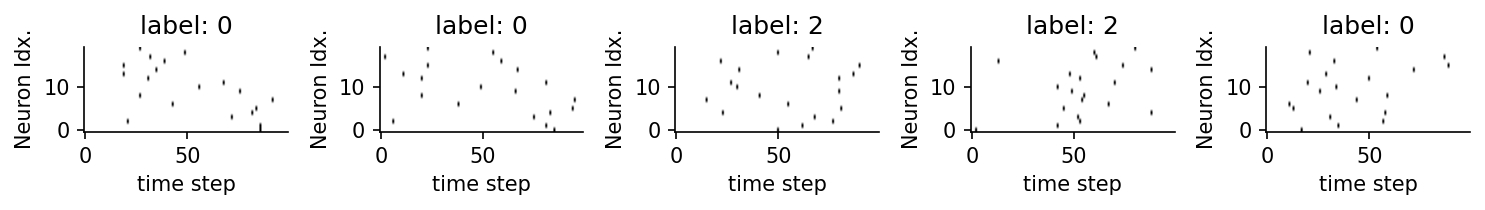

In [4]:
fig, ax = plt.subplots(1, 5, figsize=(10, 1.5), dpi=150)
for i in range(5):
    ax[i].imshow(np.transpose(ds_test[i][0]), cmap="binary", aspect="auto")
    ax[i].invert_yaxis()
    ax[i].set_xlabel("time step")
    ax[i].set_ylabel("Neuron Idx.")
    ax[i].set_title("label: " + str(ds_test[i][1]))

plt.tight_layout()
sns.despine()

## Set up the model

In [5]:
# Model Parameters
batch_size = 1
beta = 5
device = torch.device("cpu")
dtype = torch.float


nb_hidden_units = 64
tau_mem = 20e-3
tau_syn = 10e-3
tau_readout = duration

lr = 5e-3
nb_epochs = 50

anneal_start = 250
anneal_step = 5
anneal_interval = 10

In [6]:
import numpy as np
import torch
from torch.nn import Parameter

from stork import activations
from stork.nodes.base import CellGroup


class OnlineLIFGroup(CellGroup):
    def __init__(
        self,
        shape,
        tau_mem=10e-3,
        tau_syn=5e-3,
        diff_reset=False,
        activation=activations.SuperSpike,
        dropout_p=0.0,
        stateful=False,
        name="LIFGroup",
        regularizers=None,
        tau_rise=5e-3,
        tau_decay=10e-3,
        **kwargs
    ):
        """
        Leaky Integrate-and-Fire neuron with decaying synaptic input current.
        It has three state variables that are scalars and are updated at every time step:
        `mem` is for the membrane potential, `syn` is for the synaptic input current, and `out` is 0/1 depending on
        whether the neuron produces a spike.

        Args:
            :param shape: The number of units in this group
            :type shape: int or tuple of int
            :param tau_mem: The membrane time constant in s, defaults to 10e-3
            :type tau_mem: float
            :param tau_syn: The synaptic time constant in s, defaults to 5e-3
            :type tau_syn: float
            :param diff_reset: Whether or not to differentiate through the reset term, defaults to False
            :type diff_reset: bool
            :param activation: The surrogate derivative enabled activation function, defaults to stork.activations.SuperSpike
            :type activation: stork.activations
            :param dropout_p: probability that some elements of the input will be zeroed, defaults to 0.0
            :type dropout_p: float
            :param stateful: Whether or not to reset the state of the neurons between mini-batches, defaults to False
            :type stateful: bool
            :param regularizers: List of regularizers
        """

        super().__init__(
            shape,
            dropout_p=dropout_p,
            stateful=stateful,
            name=name,
            regularizers=regularizers,
            **kwargs
        )
        self.tau_mem = tau_mem
        self.tau_syn = tau_syn
        self.tau_rise = tau_rise
        self.tau_decay = tau_decay

        self.act_fn = activation
        self.spk_nl = activation.apply
        self.diff_reset = diff_reset
        self.mem = None
        self.syn = None
        self.pre_z = None
        self.pre_z_tilde = None

    def configure(self, batch_size, nb_steps, time_step, device, dtype):
        self.dcy_mem = float(np.exp(-time_step / self.tau_mem))
        self.scl_mem = 1.0 - self.dcy_mem
        self.dcy_syn = float(np.exp(-time_step / self.tau_syn))
        self.scl_syn = 1.0 - self.dcy_syn

        self.dcy_z = np.exp(-time_step / self.tau_rise)
        self.dcy_z_tilde = np.exp(-time_step / self.tau_decay)
        self.scl_z_tilde = 1 - self.dcy_z_tilde

        super().configure(batch_size, nb_steps, time_step, device, dtype)

    def reset_state(self, batch_size=None):
        super().reset_state(batch_size)
        self.mem = self.get_state_tensor("mem", state=self.mem)
        self.syn = self.get_state_tensor("syn", state=self.syn)
        self.pre_z = self.get_state_tensor("pre_z", state=self.pre_z)
        self.pre_z_tilde = self.get_state_tensor("pre_z_tilde", state=self.pre_z_tilde)
        self.out = self.states["out"] = torch.zeros(
            self.int_shape, device=self.device, dtype=self.dtype
        )

    def get_spike_and_reset(self, mem):
        mthr = mem - 1.0
        out = self.spk_nl(mthr)

        if self.diff_reset:
            rst = out
        else:
            # if differentiation should not go through reset term, detach it from the computational graph
            rst = out.detach()

        return out, rst

    def forward(self):
        # spike & reset
        new_out, rst = self.get_spike_and_reset(self.mem)

        # print("input_shape", self.name, self.input.shape, self.input)
        # print("zsshape", self.pre_z.shape, self.pre_z)
        # print("z_tilde_shape", self.pre_z_tilde.shape)
        # print()

        # synaptic & membrane dynamics
        new_syn = self.dcy_syn * self.syn + self.input
        new_mem = (self.dcy_mem * self.mem + self.scl_mem * self.syn) * (
            1.0 - rst
        )  # multiplicative reset

        self.out = self.states["out"] = new_out
        self.mem = self.states["mem"] = new_mem
        self.syn = self.states["syn"] = new_syn


## Test OnlineLIF

In [7]:
tau_mem = tau_decay = 10e-3
tau_syn = tau_rise = 5e-3

act_fn = stork.activations.CustomSpike
act_fn.escape_noise_type = "step"
act_fn.escape_noise_params = {}
act_fn.surrogate_type = "SuperSpike"
act_fn.surrogate_params = {"beta": beta}

In [8]:
neuron = OnlineLIFGroup(
    shape=(1),
    tau_mem=tau_mem,
    tau_syn=tau_syn,
    activation=act_fn,
    name="OLIF",
    tau_rise=tau_rise,
    tau_decay=tau_decay,
)

In [9]:
model = RecurrentSpikingModel(batch_size, nb_time_steps, nb_inputs, device, dtype)

input_group = model.add_group(InputGroup(nb_inputs))
hidden_neurons = model.add_group(
    OnlineLIFGroup(
        1,
        tau_mem=tau_mem,
        tau_syn=tau_syn,
        activation=act_fn,
        name="OLIF",
        tau_rise=tau_rise,
        tau_decay=tau_decay,
    )
)
hid2  = model.add_group(
    OnlineLIFGroup(
        1,
        tau_mem=tau_mem,
        tau_syn=tau_syn,
        activation=act_fn,
        name="OLIF2",
        tau_rise=tau_rise,
        tau_decay=tau_decay,
    )
)

In [10]:
con = model.add_connection(Connection(input_group, hidden_neurons))
con2 = model.add_connection(Connection(hidden_neurons, hid2))

In [11]:
sigma_u = 1.0
nu = nb_spikes / duration

initializer = FluctuationDrivenCenteredNormalInitializer(
    sigma_u=1.1, nu=nu, timestep=dt
)

con.init_parameters(initializer=initializer)
con2.init_parameters(initializer=initializer)


In [12]:
model.add_monitor(stork.monitors.StateMonitor(model.groups[1], "out"))
model.add_monitor(stork.monitors.StateMonitor(model.groups[1], "mem"))
model.add_monitor(stork.monitors.StateMonitor(model.groups[1], "syn"))
model.add_monitor(stork.monitors.StateMonitor(model.groups[1], "pre_z"))
model.add_monitor(stork.monitors.StateMonitor(model.groups[1], "pre_z_tilde"))
model.add_monitor(stork.monitors.StateMonitor(model.groups[1], "input"))

model.add_monitor(stork.monitors.StateMonitor(model.groups[2], "out"))
model.add_monitor(stork.monitors.StateMonitor(model.groups[2], "mem"))
model.add_monitor(stork.monitors.StateMonitor(model.groups[2], "syn"))
model.add_monitor(stork.monitors.StateMonitor(model.groups[2], "pre_z"))
model.add_monitor(stork.monitors.StateMonitor(model.groups[2], "pre_z_tilde"))
model.add_monitor(stork.monitors.StateMonitor(model.groups[2], "input"))


In [13]:
loss_stack = stork.loss_stacks.MaxOverTimeCrossEntropy()

In [14]:
opt = stork.optimizers.SMORMS3
generator = StandardGenerator(nb_workers=2)

In [15]:
model.configure(input=input_group,
                output=hid2,
                loss_stack=loss_stack,
                generator=generator,
                optimizer=opt,
                optimizer_kwargs=dict(lr=lr),
                time_step=dt,
                )

In [16]:
print(con.get_weights().shape)
print(con.dst.pre_z.shape)
print(con.dst.pre_z_tilde.shape)
print(con2.dst.pre_z_tilde)

torch.Size([1, 20])
torch.Size([1, 20])
torch.Size([1, 20])
tensor([[0.]])


In [17]:
print(hidden_neurons.pre_z_tilde)
res = model.monitor(ds_test)
print(len(res))
print(res.keys())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
12
dict_keys(['out-OLIF', 'mem-OLIF', 'syn-OLIF', 'pre_z-OLIF', 'pre_z_tilde-OLIF', 'input-OLIF', 'out-OLIF2', 'mem-OLIF2', 'syn-OLIF2', 'pre_z-OLIF2', 'pre_z_tilde-OLIF2', 'input-OLIF2'])


In [18]:
len(ds_test)

30

In [19]:
res["out-OLIF"].shape

torch.Size([30, 100, 1])

In [25]:
total_spikes = torch.sum(res["out-OLIF"][0])
print(total_spikes)

tensor(4.)


torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])


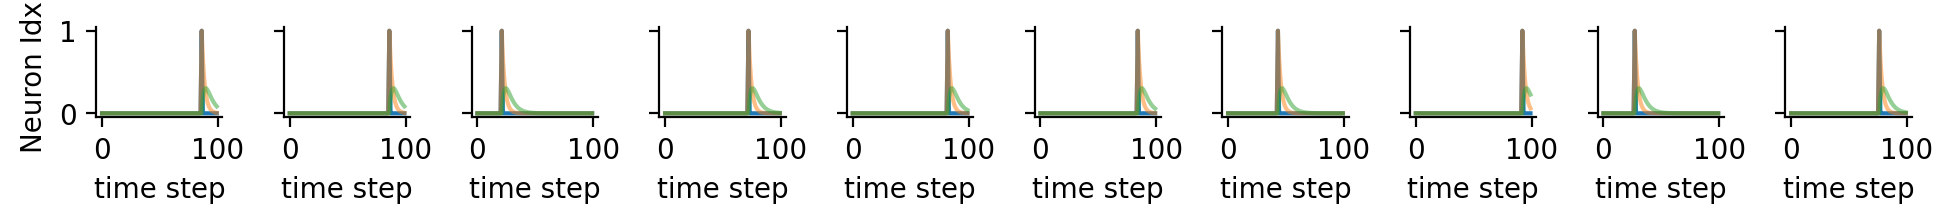

In [51]:
# print input of neuron i together with pre_z of that neuron

fig, ax = plt.subplots(1, 10, figsize=(10,1.2), sharex=True, sharey=True, dpi=200)

for i in range(10):
    ax[i].plot(np.transpose(ds_test[0][0][:, i]))
    print(res["pre_z-OLIF"][0][:, i].shape)
    ax[i].plot(res["pre_z-OLIF"][0][:, i], alpha=0.5)
    ax[i].plot(res["pre_z_tilde-OLIF"][0][:, i], alpha=0.5)
    ax[i].set_xlabel("time step")
ax[0].set_ylabel("Neuron Idx.")
    
plt.tight_layout()
sns.despine()

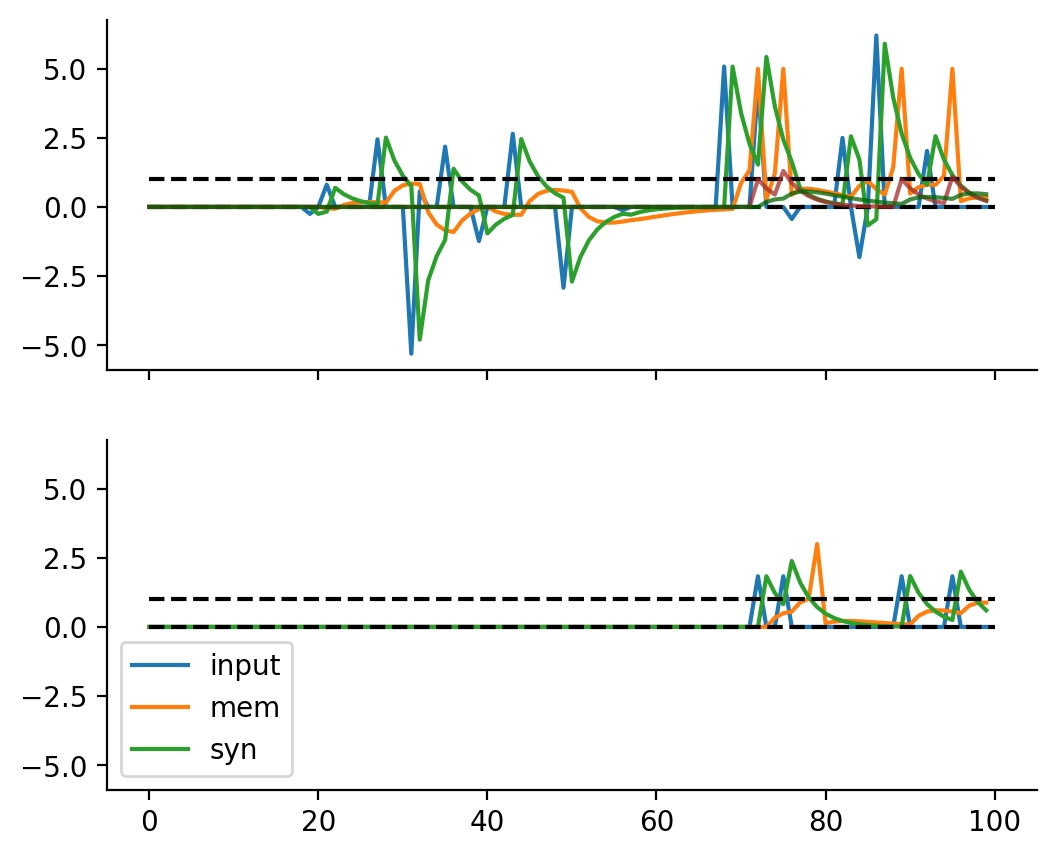

In [69]:
fig, ax = plt.subplots(2,1, figsize=(6,5), dpi=200, sharex=True, sharey=True)
ax[0].plot(res["input-OLIF"][0], label="input")
ax[0].plot(res["mem-OLIF"][0]+5*res["out-OLIF"][0], label="mem")
ax[0].plot(res["syn-OLIF"][0], label="syn")
ax[0].hlines(0, 0, nb_time_steps, color="k", ls="--")
ax[0].hlines(1, 0, nb_time_steps, color="k", ls="--")

ax[1].plot(res["input-OLIF2"][0], label="input")
ax[1].plot(res["mem-OLIF2"][0]+3*res["out-OLIF2"][0], label="mem")
ax[1].plot(res["syn-OLIF2"][0], label="syn")
ax[0].plot(res["pre_z-OLIF2"][0], label="z", color="brown", alpha=0.75)
ax[0].plot(res["pre_z_tilde-OLIF2"][0], label="z_tilde", color="darkgreen", alpha=0.75)
ax[1].hlines(0, 0, nb_time_steps, color="k", ls="--")
ax[1].hlines(1, 0, nb_time_steps, color="k", ls="--")


plt.legend(loc="lower left")
sns.despine()

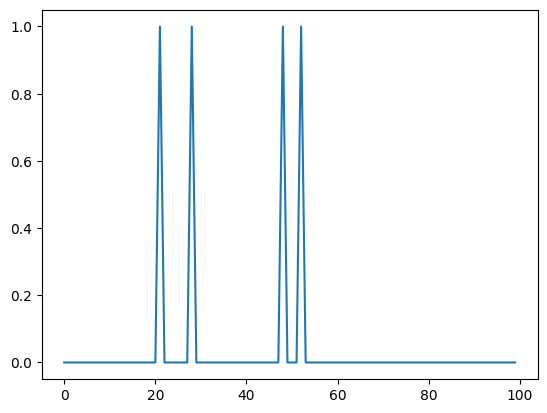

In [ ]:
plt.plot(model.groups[1].get_out_sequence().detach()[0][:])

In [ ]:
import torch.nn as nn
import stork.nodes.base
from stork import generators
from stork import loss_stacks
from stork import monitors
import time


class OnlineSuperSpikeModel(nn.Module):
    def __init__(
        self,
        batch_size,
        nb_time_steps,
        nb_inputs,
        device=torch.device("cpu"),
        dtype=torch.float,
        sparse_input=False,
    ):
        super(OnlineSuperSpikeModel, self).__init__()
        self.batch_size = batch_size
        self.nb_time_steps = nb_time_steps
        self.nb_inputs = nb_inputs

        self.device = device
        self.dtype = dtype

        self.fit_runs = []

        self.groups = []
        self.connections = []
        self.devices = []
        self.monitors = []
        self.hist = []

        self.optimizer = None
        self.input_group = None
        self.output_group = None
        self.sparse_input = sparse_input

    def configure(
        self,
        input,
        output,
        loss_stack=None,
        optimizer=None,
        optimizer_kwargs=None,
        generator=None,
        time_step=1e-3,
        wandb=None,
        anneal_interval=0,
        anneal_step=0,
        anneal_start=0,
    ):
        self.input_group = input
        self.output_group = output
        self.time_step = time_step
        self.wandb = wandb
        self.anneal_interval = anneal_interval
        self.anneal_step = anneal_step
        self.anneal_start = anneal_start

        if loss_stack is not None:
            self.loss_stack = loss_stack
        else:
            self.loss_stack = loss_stacks.MaxOverTimeCrossEntropy()

        if generator is None:
            self.data_generator_ = generators.StandardGenerator()
        else:
            self.data_generator_ = generator

        # configure data generator
        self.data_generator_.configure(
            self.batch_size,
            self.nb_time_steps,
            self.nb_inputs,
            self.time_step,
            device=self.device,
            dtype=self.dtype,
        )

        for o in self.groups + self.connections:
            o.configure(
                self.batch_size,
                self.nb_time_steps,
                self.time_step,
                self.device,
                self.dtype,
            )

        if optimizer is None:
            optimizer = torch.optim.Adam

        if optimizer_kwargs is None:
            optimizer_kwargs = dict(lr=1e-3, betas=(0.9, 0.999))

        self.optimizer_class = optimizer
        self.optimizer_kwargs = optimizer_kwargs
        self.configure_optimizer(self.optimizer_class, self.optimizer_kwargs)
        self.to(self.device)

    def configure_optimizer(self, optimizer_class, optimizer_kwargs):
        if optimizer_kwargs is not None:
            self.optimizer_instance = optimizer_class(
                self.parameters(), **optimizer_kwargs
            )
        else:
            self.optimizer_instance = optimizer_class(self.parameters())

    def prepare_data(self, dataset):
        return self.data_generator_.prepare_data(dataset)

    def data_generator(self, dataset, shuffle=True):
        return self.data_generator_(dataset, shuffle=shuffle)

    def add_group(self, group):
        self.groups.append(group)
        self.add_module("group%i" % len(self.groups), group)
        return group

    def add_connection(self, con):
        self.connections.append(con)
        self.add_module("con%i" % len(self.connections), con)
        return con

    def add_monitor(self, monitor):
        self.monitors.append(monitor)
        return monitor

    def evolve_all(self):
        for g in self.groups:
            g.evolve()
            g.clear_input()

    def apply_constraints(self):
        for c in self.connections:
            c.apply_constraints()

    def propagate_all(self):
        for c in self.connections:
            c.propagate()

    def execute_all(self):
        for d in self.devices:
            d.execute()

    def monitor_all(self):
        for m in self.monitors:
            m.execute()

    def reset_states(self, batch_size=None):
        for g in self.groups:
            g.reset_state(batch_size)

    def compute_regularizer_losses(self):
        reg_loss = torch.zeros(1, device=self.device)
        for g in self.groups:
            reg_loss += g.get_regularizer_loss()
        for c in self.connections:
            reg_loss += c.get_regularizer_loss()
        return reg_loss

    def run(self, x_batch, cur_batch_size=None, record=False):
        if cur_batch_size is None:
            cur_batch_size = len(x_batch)
        self.reset_states(cur_batch_size)
        self.input_group.feed_data(x_batch)
        for t in range(self.nb_time_steps):
            stork.nodes.base.CellGroup.clk = t
            self.evolve_all()
            self.propagate_all()
            self.execute_all()
            if record:
                self.monitor_all()
        self.out = self.output_group.get_out_sequence()
        return self.out

    def forward_pass(self, x_batch, cur_batch_size, record=False):
        # run recurrent dynamics
        us = self.run(x_batch, cur_batch_size, record=record)
        return us

    def get_total_loss(self, output, target_y, regularized=True):
        if type(target_y) in (list, tuple):
            target_y = [ty.to(self.device) for ty in target_y]
        else:
            target_y = target_y.to(self.device)

        self.out_loss = self.loss_stack(output, target_y)

        if regularized:
            self.reg_loss = self.compute_regularizer_losses()
            total_loss = self.out_loss + self.reg_loss
        else:
            total_loss = self.out_loss

        return total_loss

    def evaluate(self, test_dataset, train_mode=False, one_batch=False):
        self.train(train_mode)
        self.prepare_data(test_dataset)
        metrics = []
        for local_X, local_y in self.data_generator(test_dataset, shuffle=False):
            output = self.forward_pass(local_X, cur_batch_size=len(local_X))
            total_loss = self.get_total_loss(output, local_y)
            # store loss and other metrics
            metrics.append(
                [self.out_loss.item(), self.reg_loss.item()] + self.loss_stack.metrics
            )
            if one_batch:
                break

        return np.mean(np.array(metrics), axis=0)

    def train_epoch(self, dataset, shuffle=True):
        self.train(True)
        self.prepare_data(dataset)
        metrics = []
        for local_X, local_y in self.data_generator(dataset, shuffle=shuffle):
            output = self.forward_pass(local_X, cur_batch_size=len(local_X))
            total_loss = self.get_total_loss(output, local_y)

            # store loss and other metrics
            metrics.append(
                [self.out_loss.item(), self.reg_loss.item()] + self.loss_stack.metrics
            )

            # Use autograd to compute the backward pass.
            self.optimizer_instance.zero_grad()
            total_loss.backward()

            self.optimizer_instance.step()
            self.apply_constraints()

        return np.mean(np.array(metrics), axis=0)

    def get_metric_names(self, prefix="", postfix=""):
        metric_names = ["loss", "reg_loss"] + self.loss_stack.get_metric_names()
        return ["%s%s%s" % (prefix, k, postfix) for k in metric_names]

    def get_metrics_string(self, metrics_array, prefix="", postfix=""):
        s = ""
        names = self.get_metric_names(prefix, postfix)
        for val, name in zip(metrics_array, names):
            if "acc" in name:
                s = s + " {} = {:.1%},".format(name, val)
            else:
                s = s + " {} = {:.3e},".format(name, val)
        return s[:-1]

    def get_metrics_history_dict(self, metrics_array, prefix="", postfix=""):
        " Create metrics history dict. " ""
        s = ""
        names = self.get_metric_names(prefix, postfix)
        history = {name: metrics_array[:, k] for k, name in enumerate(names)}
        return history

    def fit_validate(
        self,
        dataset,
        valid_dataset,
        nb_epochs=10,
        verbose=True,
        log_interval=10,
        anneal=False,
    ):
        self.hist_train = []
        self.hist_valid = []
        self.wall_clock_time = []
        for ep in range(nb_epochs):
            t_start = time.time()
            self.train()
            ret_train = self.train_epoch(dataset)

            self.train(False)
            ret_valid = self.evaluate(valid_dataset)
            self.hist_train.append(ret_train)
            self.hist_valid.append(ret_valid)

            if self.wandb is not None:
                self.wandb.log(
                    {
                        key: value
                        for (key, value) in zip(
                            self.get_metric_names()
                            + self.get_metric_names(prefix="val_"),
                            ret_train.tolist() + ret_valid.tolist(),
                        )
                    }
                )

            if verbose:
                if ep % log_interval == 0:
                    t_iter = time.time() - t_start
                    self.wall_clock_time.append(t_iter)
                    print(
                        "%02i %s --%s t_iter=%.2f"
                        % (
                            ep,
                            self.get_metrics_string(ret_train),
                            self.get_metrics_string(ret_valid, prefix="val_"),
                            t_iter,
                        )
                    )
            if anneal:
                if ep >= self.anneal_start:
                    if (ep - self.anneal_start) % self.anneal_interval == 0:
                        for g in range(1, len(self.groups) - 1):
                            try:
                                beta = self.groups[g].act_fn.surrogate_params["beta"]
                                print("beta", beta)
                                self.groups[g].act_fn.surrogate_params["beta"] = (
                                    beta + self.anneal_step
                                )
                                self.groups[g].spk_nl = self.groups[g].act_fn.apply
                                print(
                                    "annealed",
                                    self.groups[g].act_fn.surrogate_params["beta"],
                                )
                                if "beta" in self.groups[g].act_fn.escape_noise_params:
                                    beta = self.groups[g].act_fn.escape_noise_params[
                                        "beta"
                                    ]
                                    print("noise beta", beta)
                                    self.groups[g].act_fn.escape_noise_params[
                                        "beta"
                                    ] = (beta + self.anneal_step)
                                    self.groups[g].spk_nl = self.groups[g].act_fn.apply
                                    print(
                                        "annealed noise params",
                                        self.groups[g].act_fn.escape_noise_params[
                                            "beta"
                                        ],
                                    )
                            except:
                                beta = self.groups[g].act_fn.beta
                                print("beta", beta)
                                self.groups[g].act_fn.beta = beta + self.anneal_step
                                self.groups[g].spk_nl = self.groups[g].act_fn.apply
                                print("annealed", self.groups[g].act_fn.beta)

        self.hist = np.concatenate(
            (np.array(self.hist_train), np.array(self.hist_valid))
        )
        self.fit_runs.append(self.hist)
        dict1 = self.get_metrics_history_dict(np.array(self.hist_train), prefix="")
        dict2 = self.get_metrics_history_dict(np.array(self.hist_valid), prefix="val_")
        history = {**dict1, **dict2}
        return history

    def predict(self, data, train_mode=False):
        self.train(train_mode)
        if type(data) in [torch.Tensor, np.ndarray]:
            output = self.forward_pass(data, cur_batch_size=len(data))
            pred = self.loss_stack.predict(output)
            return pred
        else:
            self.prepare_data(data)
            pred = []
            for local_X, _ in self.data_generator(data, shuffle=False):
                data_local = local_X.to(self.device)
                output = self.forward_pass(data_local, cur_batch_size=len(local_X))
                pred.append(self.loss_stack.predict(output).detach().cpu())
            return torch.cat(pred, dim=0)

    def monitor(self, dataset):
        self.prepare_data(dataset)

        # Prepare a list for each monitor to hold the batches
        results = [[] for _ in self.monitors]
        for local_X, local_y in self.data_generator(dataset, shuffle=False):
            for m in self.monitors:
                m.reset()

            output = self.forward_pass(
                local_X, record=True, cur_batch_size=len(local_X)
            )

            for k, mon in enumerate(self.monitors):
                results[k].append(mon.get_data())

        return [torch.cat(res, dim=0) for res in results]

    def summary(self):
        """Print model summary"""

        print("\n# Model summary")
        print("\n## Groups")
        for group in self.groups:
            if group.name is None or group.name == "":
                print("no name, %s" % (group.shape,))
            else:
                print("%s, %s" % (group.name, group.shape))

        print("\n## Connections")
        for con in self.connections:
            print(con)

In [ ]:
model = OnlineSuperSpikeModel(batch_size, nb_time_steps, nb_inputs, device, dtype)

Add neuron groups

In [ ]:
input_group = model.add_group(InputGroup(nb_inputs))
hidden_neurons = model.add_group(
    LIFGroup(nb_hidden_units, tau_mem=tau_mem, tau_syn=tau_syn, activation=act_fn)
)
readout_group = model.add_group(
    ReadoutGroup(nb_classes, tau_mem=tau_readout, tau_syn=tau_syn, initial_state=-1e-2)
)

Add synapses between the neuron groups

In [ ]:
con = model.add_connection(Connection(input_group, hidden_neurons))
con_ro = model.add_connection(Connection(hidden_neurons, readout_group))

Add regularizers

In [ ]:
# Define regularizer parameters (set regularizer strenght to 0, if you don't want to use them)
lowerBoundL2Strength = 100
lowerBoundL2Threshold = 1e-3
upperBoundL2Strength = 0.1
upperBoundL2Threshold = (
    4  # Regularizes spikecount: 4 spikes ~ 20 Hz in 200ms simulation time
)

# Define regularizer list
regs = []

regLB = stork.regularizers.LowerBoundL2(
    lowerBoundL2Strength, threshold=lowerBoundL2Threshold, dims=False
)
regs.append(regLB)
regUB = stork.regularizers.UpperBoundL2(
    upperBoundL2Strength, threshold=upperBoundL2Threshold, dims=1
)
regs.append(regUB)

# Add to neurons
hidden_neurons.regularizers.extend(regs)

We initialize the network in the Flucutation-Driven regime, with a target membrane potential standard deviation $\sigma_U=1.0$

In [ ]:
sigma_u = 1.0
nu = nb_spikes / duration

initializer = FluctuationDrivenCenteredNormalInitializer(
    sigma_u=1.0, nu=nu, timestep=dt
)

con.init_parameters(initializer=initializer)
con_ro.init_parameters(initializer=initializer)

Add monitors for spikes and membrane potential

In [ ]:
model.add_monitor(stork.monitors.SpikeCountMonitor(model.groups[1]))
model.add_monitor(stork.monitors.StateMonitor(model.groups[1], "out"))

Choose loss function (We chose a maximum over time crossentropy loss, where the class is chosen according to the readout neuron that has the highest membrane potential over the simulation time)

In [ ]:
loss_stack = stork.loss_stacks.MaxOverTimeCrossEntropy()

We select the SMORMS3 optimizer

In [ ]:
opt = stork.optimizers.SMORMS3
generator = StandardGenerator(nb_workers=2)

In [ ]:
model.configure(
    input=input_group,
    output=readout_group,
    loss_stack=loss_stack,
    generator=generator,
    optimizer=opt,
    optimizer_kwargs=dict(lr=lr),
    time_step=dt,
    anneal_start=anneal_start,
    anneal_step=anneal_step,
    anneal_interval=anneal_interval,
)

Before we train the model, we monitor the spikes

In [ ]:
# Monitors spike counts before training
res = model.monitor(ds_test)
total_spikes = torch.sum(res[0]).item()

results = {}
res = model.monitor(ds_test)
total_spikes_per_layer = [torch.sum(res[i]).item() for i in range(1)]
results["avg_layer_freq_init"] = [
    nb / len(ds_test) / duration / nb_hidden_units for nb in total_spikes_per_layer
]

print(results)

{'avg_layer_freq_init': [6.4039062499999995]}


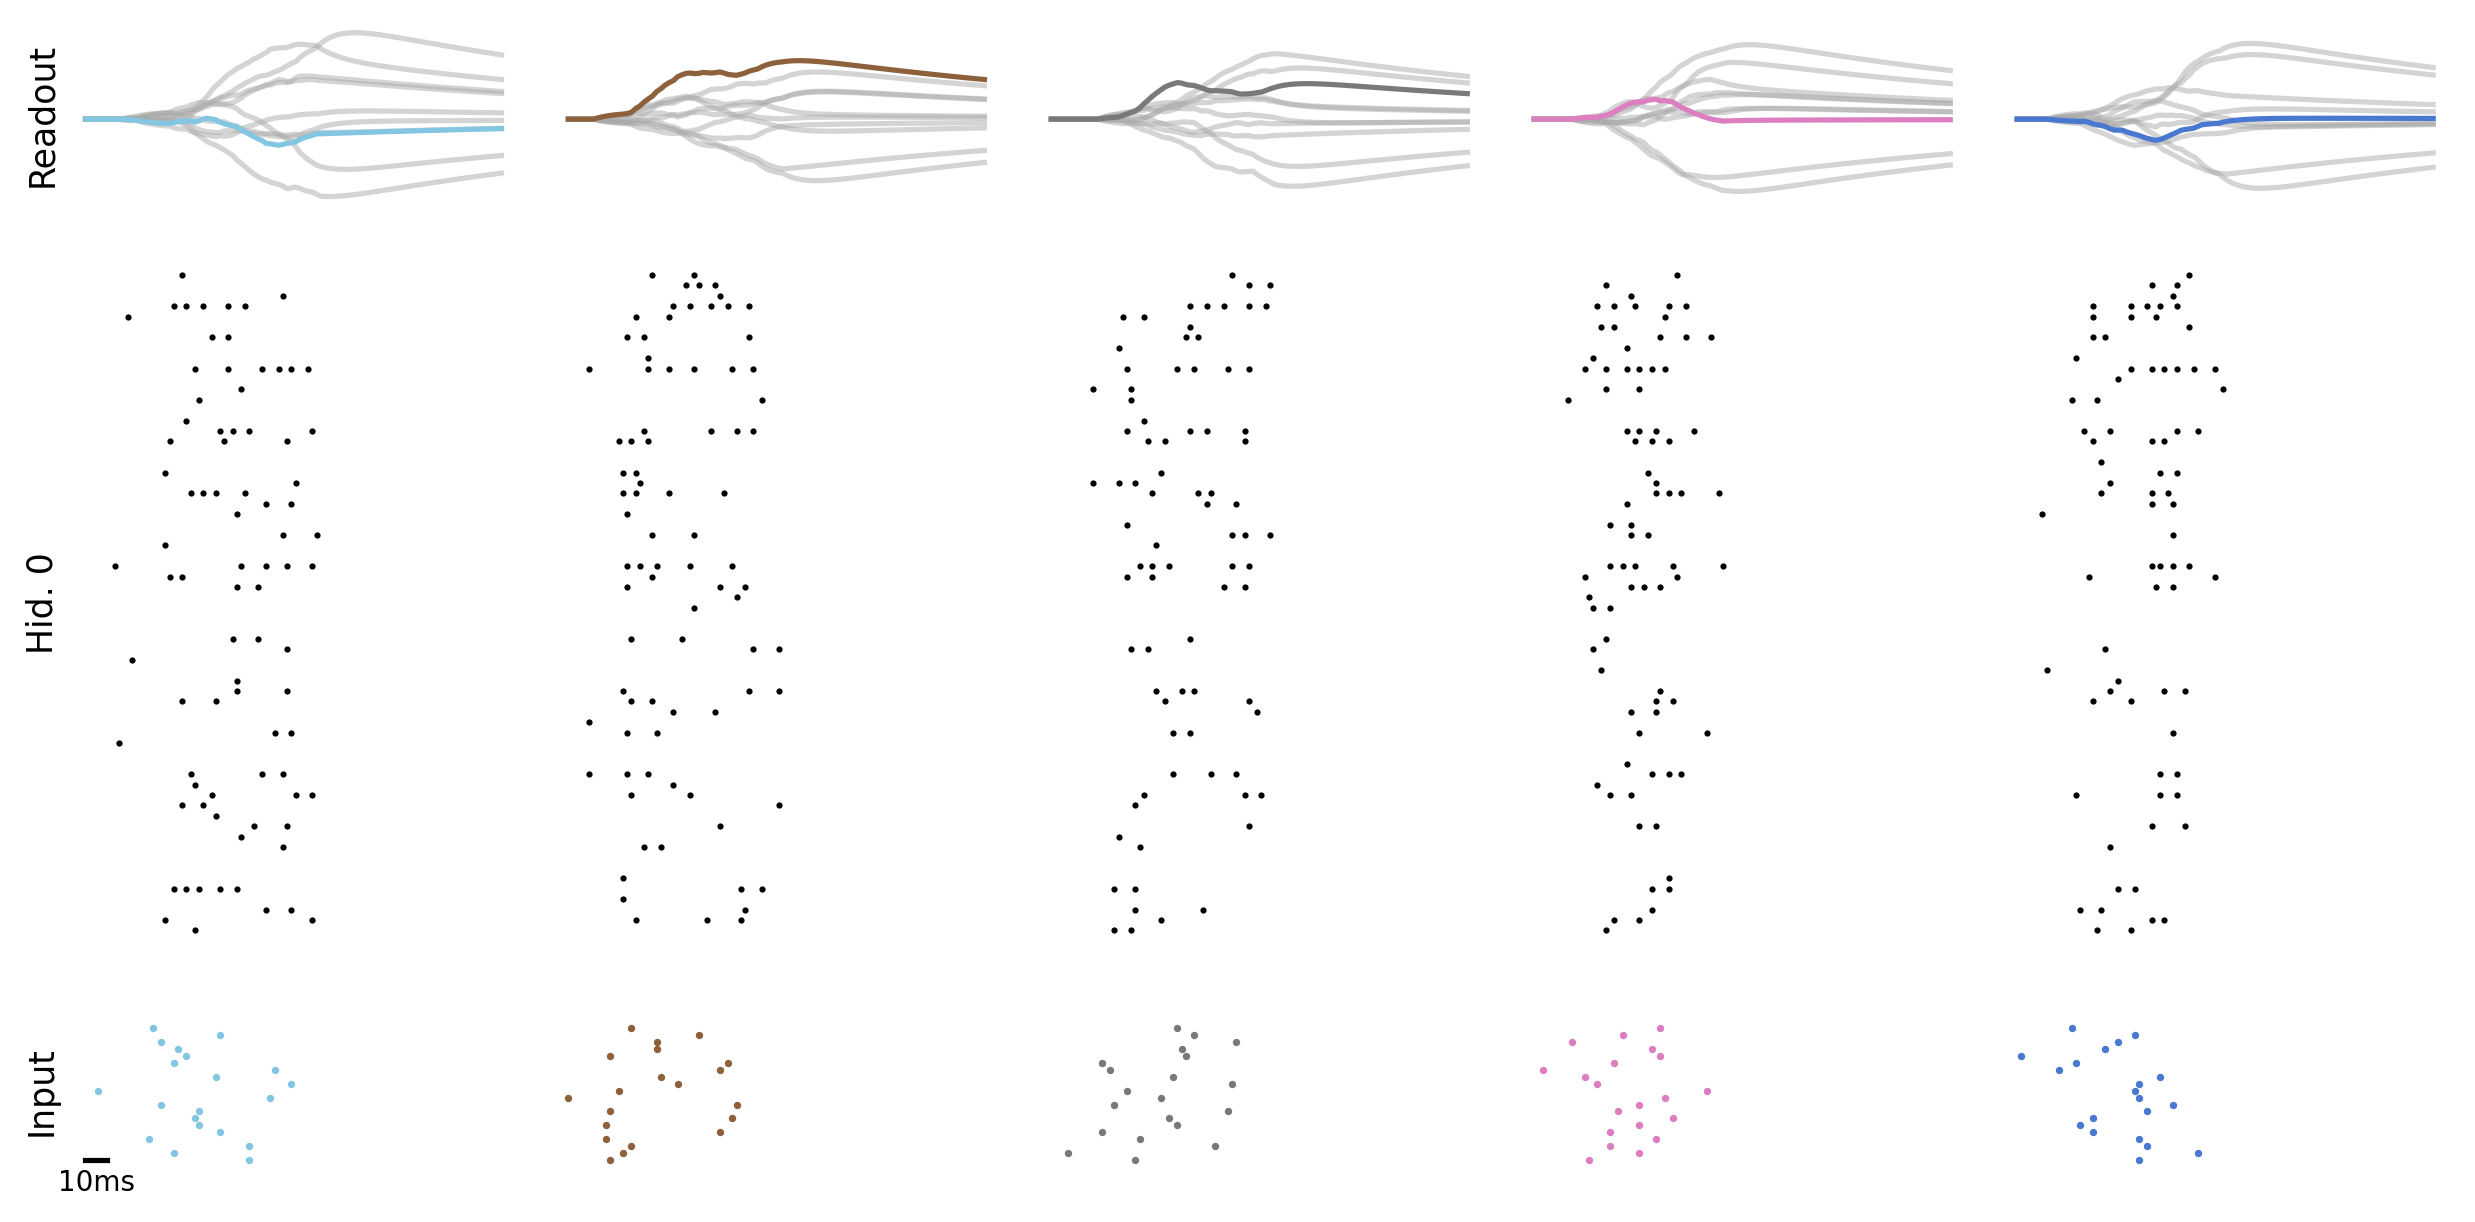

In [ ]:
stork.plotting.plot_activity_snapshot(model, data=ds_test, figsize=(10, 5), dpi=250)

## Training

takes around 13-20 minutes

In [ ]:
history = model.fit_validate(
    ds_train,
    ds_valid,
    nb_epochs=nb_epochs,
    verbose=True,
    anneal=False,
    log_interval=5,
)

results["train_loss"] = history["loss"].tolist()
results["train_acc"] = history["acc"].tolist()
results["valid_loss"] = history["val_loss"].tolist()
results["valid_acc"] = history["val_acc"].tolist()

/home/gygajuli/miniconda3/envs/sg/lib/python3.10/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


00  loss = 2.282e+00, reg_loss = 3.176e-05, acc = 20.1% -- val_loss = 2.039e+00, val_reg_loss = 2.124e-05, val_acc = 32.0% t_iter=61.44


KeyboardInterrupt: 

#### Monitor the model again after training

In [ ]:
res = model.monitor(ds_test)
total_spikes_per_layer = [torch.sum(res[i]).item() for i in range(1)]
results["avg_layer_freq"] = [
    nb / len(ds_test) / duration / nb_hidden_units for nb in total_spikes_per_layer
]

## Test

In [ ]:
scores = model.evaluate(ds_test).tolist()
results["test_loss"], _, results["test_acc"] = scores

Test loss:  0.22094524048268796
Test acc.:  94.1 %


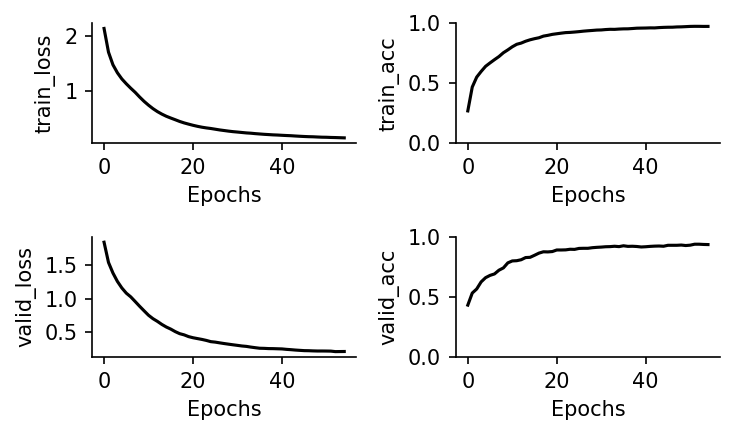

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(5, 3), dpi=150)

for i, n in enumerate(["train_loss", "train_acc", "valid_loss", "valid_acc"]):
    if i < 2:
        a = ax[0][i]
    else:
        a = ax[1][i - 2]

    a.plot(results[n], color="black")
    a.set_xlabel("Epochs")
    a.set_ylabel(n)

ax[0, 1].set_ylim(0, 1)
ax[1, 1].set_ylim(0, 1)

sns.despine()
plt.tight_layout()

print("Test loss: ", results["test_loss"])
print("Test acc.: ", round(results["test_acc"] * 100, 2), "%")

<Figure size 960x720 with 0 Axes>

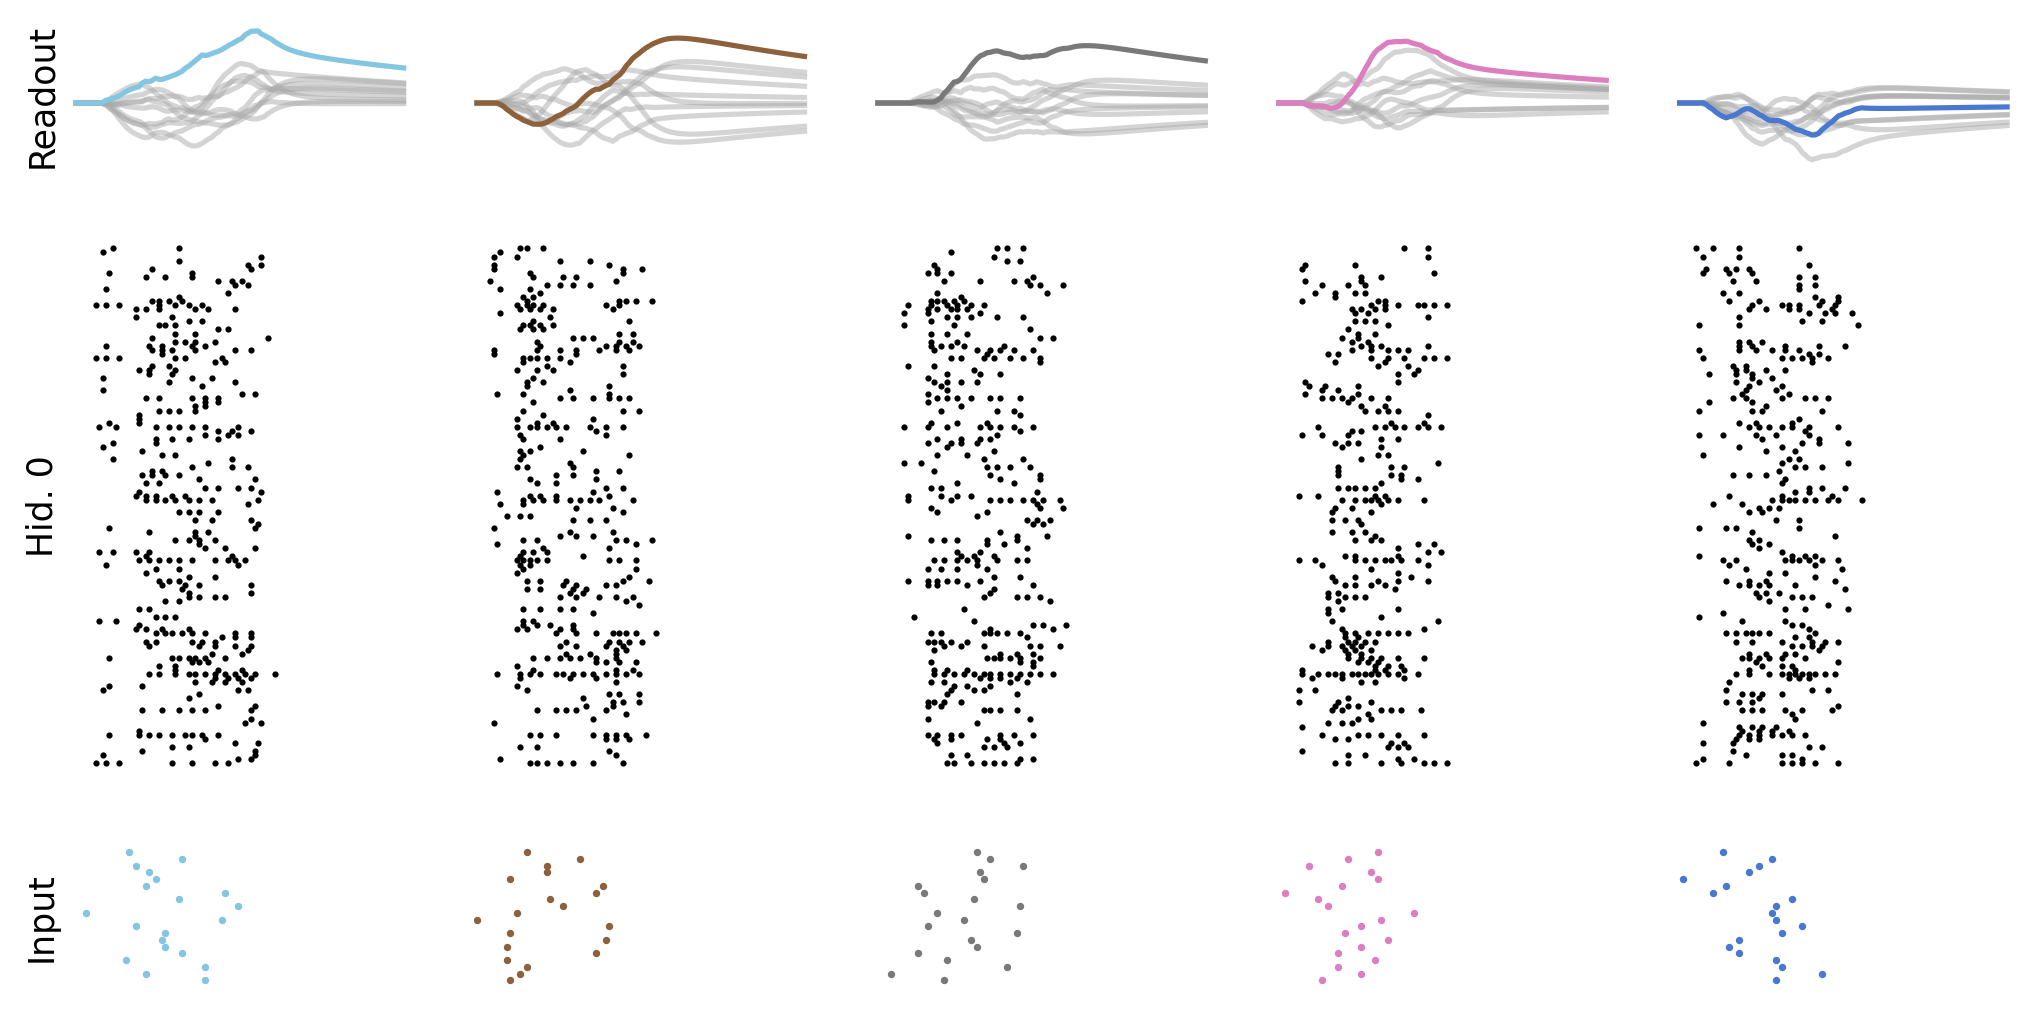

In [ ]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(model, data=ds_test, nb_samples=5)